# Aid Amyotrophic Lateral Sclerosis via Knowledge Graph

## 1. Corpus selection from PubMed 

In [5]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [6]:
# url for search query as follows 'https://pubmed.ncbi.nlm.nih.gov//?term=ALS+neurodegenerative+disease+treatment&filter=years.2013-2023'
base_url = 'https://pubmed.ncbi.nlm.nih.gov'
search_query = '/?term=ALS+neurodegenerative+disease+treatment&filter=years.2013-2023'

titles = []
pmids = []
abstracts = []

# Scraping 5 Pages of papers from 2013-2023. we can change this according to our interest
num_pages = 5  

# Looping through multiple pages
for page in range(1, num_pages + 1):
    
    page_url = base_url + search_query + f'&page={page}'

    response = requests.get(page_url)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Extracting and append titles, PMIDs, and Abstracts 
    for papers in soup.find_all('div', class_='docsum-content'):
        # title
        title = papers.find('a', class_='docsum-title').get_text(strip=True)
        titles.append(title)
        
        # PMID
        pmid_data = papers.find('span', class_='docsum-pmid').get_text(strip=True).replace('PMID: ', '')
        pmids.append(pmid_data)
        
        # parsing to the individual paper page
        link_tag = papers.find('a', class_='docsum-title')
        if link_tag and 'href' in link_tag.attrs:
            paper_url = base_url + link_tag['href']
            
            paper_response = requests.get(paper_url)
            paper_soup = BeautifulSoup(paper_response.text, 'html.parser')
            
            # Getting abstract from individual paper's page
            abstract_div = paper_soup.find('div', class_='abstract-content')
            if abstract_div:
                abstract = abstract_div.get_text(strip=True)
            else:
                abstract = "Abstract not found."
            abstracts.append(abstract)
        else:
            abstracts.append("No link found.")

# Creating a DataFrame
data = {
    'Title': titles,
    'PMID': pmids,
    'Abstract': abstracts
}
df = pd.DataFrame(data)

df.head()
#print(df)


,Title,PMID,Abstract
0,Amyotrophic lateral sclerosis.,36116464,Amyotrophic lateral sclerosis is a fatal CNS n...
1,Biomarkers inNeurodegenerativeDiseases: Proteo...,36012563,Neurodegenerative diseases such as amyotrophic...
2,Antisense Oligonucleotides for the Study andTr...,35653060,Amyotrophic lateral sclerosis (ALS) is a fatal...
3,iPSC-baseddiseasemodeling and drug discovery i...,35120619,It has been 15 years since the birth of human ...
4,Supporting communication for patients withneur...,26409694,"Background:Communication supports, referred to..."


## 2. Entity extraction using PubTator

In [8]:
import pandas as pd
import requests

# Function for getting annotations for a list of PMIDs
def get_annotations(pmids, format='pubtator'):
    
    # https://www.ncbi.nlm.nih.gov/research/pubtator-api/publications/export/pubtator?pmids=36012563
    base_url = 'https://www.ncbi.nlm.nih.gov/research/pubtator-api/publications/export'
    url = f'{base_url}/{format}?pmids={",".join(pmids)}'
    response = requests.get(url)
    
    if response.status_code == 200:
        return response.text
    else:
        print(f'Error: {response.status_code}')
        return None

# adding annotations to a file
def append_annotations_to_file(annotations, file_path):
    with open(file_path, 'a') as file:  # Note the 'a' for append mode
        file.write(annotations)
        
# output file path
output_file_path = r'C:\Users\pravallika\Downloads\fasak\combined-annotations.txt'

pmids = df['PMID'].astype(str).tolist() 

# Giving the format type to retrieve from PubTator
annotation_format = 'pubtator'

# Retrieve annotations for each PMID and appending to a single file
for pmid in pmids:
    annotations = get_annotations([pmid], format=annotation_format)
    if annotations:
        append_annotations_to_file(annotations, output_file_path)
    else:
        print(f'Failed to retrieve annotations for PMID {pmid}.')

print(f'All annotations have been appended to {output_file_path}.')


All annotations have been appended to C:\Users\pravallika\Downloads\fasak\combined-annotations.txt.


In [9]:
import pandas as pd
import requests

# Function for getting annotations for a single PMID
def get_annotations(pmid, format='pubtator'):
    base_url = 'https://www.ncbi.nlm.nih.gov/research/pubtator-api/publications/export'
    url = f'{base_url}/{format}?pmids={pmid}'
    response = requests.get(url)
    
    if response.status_code == 200:
        return response.text
    else:
        print(f'Error: {response.status_code}')
        return None

# Function to parse the annotations text and return a list of entities and their types
def parse_annotations(annotations):
    entity_info = []
    for line in annotations.splitlines():
        parts = line.split('\t')
        if len(parts) == 6:  
            # Extracting the entity and its type
            entity = parts[3]
            entity_type = parts[4]
            entity_info.append((entity, entity_type))  
    return entity_info

df['Entities'] = [[] for _ in range(len(df))]
df['EntityTypes'] = [[] for _ in range(len(df))]

for index, row in df.iterrows():
    annotations = get_annotations(row['PMID'])
    if annotations:
        entities_and_types = parse_annotations(annotations)
        entities, types = zip(*entities_and_types) if entities_and_types else ([], [])
        df.at[index, 'Entities'] = list(entities)
        df.at[index, 'EntityTypes'] = list(types)

print(df.head())


                                               Title      PMID  \
0                     Amyotrophic lateral sclerosis.  36116464   
1  Biomarkers inNeurodegenerativeDiseases: Proteo...  36012563   
2  Antisense Oligonucleotides for the Study andTr...  35653060   
3  iPSC-baseddiseasemodeling and drug discovery i...  35120619   
4  Supporting communication for patients withneur...  26409694   

                                            Abstract  \
0  Amyotrophic lateral sclerosis is a fatal CNS n...   
1  Neurodegenerative diseases such as amyotrophic...   
2  Amyotrophic lateral sclerosis (ALS) is a fatal...   
3  It has been 15 years since the birth of human ...   
4  Background:Communication supports, referred to...   

                                            Entities  \
0  [Amyotrophic lateral sclerosis, Amyotrophic la...   
1  [Neurodegenerative Diseases, ALS, Parkinson's ...   
2  [Oligonucleotides, ALS, Amyotrophic lateral sc...   
3  [cardinal neurodegenerative disorders, 

In [10]:
# Displaying the types Unique Entities
all_entity_types = set([etype for sublist in df['EntityTypes'] for etype in sublist])
print("Unique Entity Types:", all_entity_types)


Unique Entity Types: {'Gene', 'CellLine', 'DNAMutation', 'Chemical', 'Species', 'Disease'}


In [11]:
for etype in all_entity_types:
    df[etype] = [[] for _ in range(len(df))]

def classify_entities(row):
    for entity, entity_type in zip(row['Entities'], row['EntityTypes']):
        if entity_type in all_entity_types:
            row[entity_type].append(entity)

for index, row in df.iterrows():
    classify_entities(row)

print(df.head())


                                               Title      PMID  \
0                     Amyotrophic lateral sclerosis.  36116464   
1  Biomarkers inNeurodegenerativeDiseases: Proteo...  36012563   
2  Antisense Oligonucleotides for the Study andTr...  35653060   
3  iPSC-baseddiseasemodeling and drug discovery i...  35120619   
4  Supporting communication for patients withneur...  26409694   

                                            Abstract  \
0  Amyotrophic lateral sclerosis is a fatal CNS n...   
1  Neurodegenerative diseases such as amyotrophic...   
2  Amyotrophic lateral sclerosis (ALS) is a fatal...   
3  It has been 15 years since the birth of human ...   
4  Background:Communication supports, referred to...   

                                            Entities  \
0  [Amyotrophic lateral sclerosis, Amyotrophic la...   
1  [Neurodegenerative Diseases, ALS, Parkinson's ...   
2  [Oligonucleotides, ALS, Amyotrophic lateral sc...   
3  [cardinal neurodegenerative disorders, 

In [12]:
import numpy as np

# Function to replace an empty list with NaN
def replace_empty_with_nan(value):
    if isinstance(value, list) and not value:  
        return np.nan
    return value

df = df.applymap(replace_empty_with_nan)
print(df.head())


                                               Title      PMID  \
0                     Amyotrophic lateral sclerosis.  36116464   
1  Biomarkers inNeurodegenerativeDiseases: Proteo...  36012563   
2  Antisense Oligonucleotides for the Study andTr...  35653060   
3  iPSC-baseddiseasemodeling and drug discovery i...  35120619   
4  Supporting communication for patients withneur...  26409694   

                                            Abstract  \
0  Amyotrophic lateral sclerosis is a fatal CNS n...   
1  Neurodegenerative diseases such as amyotrophic...   
2  Amyotrophic lateral sclerosis (ALS) is a fatal...   
3  It has been 15 years since the birth of human ...   
4  Background:Communication supports, referred to...   

                                            Entities  \
0  [Amyotrophic lateral sclerosis, Amyotrophic la...   
1  [Neurodegenerative Diseases, ALS, Parkinson's ...   
2  [Oligonucleotides, ALS, Amyotrophic lateral sc...   
3  [cardinal neurodegenerative disorders, 

## 3. Entity Merging

In [13]:
import pandas as pd
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import jaccard
from fuzzywuzzy import fuzz
import numpy as np
import string

# spaCy model for lemmatization
nlp = spacy.load("en_core_web_sm")

def normalize_entity(entity):
    # Normalize, lemmatize, and remove special characters
    entity = entity.lower().translate(str.maketrans('', '', string.punctuation))
    return ' '.join([token.lemma_ for token in nlp(entity)])

def calculate_jaccard_levenshtein(entity1, entity2, omega=0.5):
    # Jaccard similarity
    vectorizer = TfidfVectorizer().fit([entity1, entity2])
    jaccard_sim = 1 - jaccard(vectorizer.transform([entity1]).toarray()[0], 
                             vectorizer.transform([entity2]).toarray()[0])
    # Levenshtein distance
    levenshtein_dist = fuzz.ratio(entity1, entity2) / 100
    # Combining both
    return (1 - omega) * jaccard_sim + omega * levenshtein_dist

all_entity_types = set([etype for sublist in df['EntityTypes'] for etype in sublist])

# Normalizing entities
for etype in all_entity_types:
    df[etype] = df[etype].apply(lambda entities: [normalize_entity(e) for e in entities] if isinstance(entities, list) else entities)

# Detecting Duplicates for each entity type
threshold = 0.8
unique_entities = {etype: set() for etype in all_entity_types}

for etype in all_entity_types:
    for entity_list in df[etype].dropna():
        for entity in entity_list:
            if all(calculate_jaccard_levenshtein(entity, existing_entity, omega=0.5) < threshold for existing_entity in unique_entities[etype]):
                unique_entities[etype].add(entity)


In [14]:
for etype, entities in unique_entities.items():
    print(f"Unique {etype}:")
    print(entities, "\n")


Unique Gene:
{'aid', 'trem2', 'gpnmb', 'trigger receptor express on myeloid cell 2', 'cyp1a2', 'il1 beta', 'nfl', 'cytochrome p450 2e1', 'interleukin1beta', 'parp', 'pkrlike er kinase', 'granulocyte colonystimulate factor', 'interleukin6', 'sod1', 'abeta', 'il6', 'alphasyn', 'thy1', 'alphasynuclein', '  r', 'c9orf72', 'pgrn', 'tnfalpha', 'glycoprotein nmb', 'age', 'tau', 'perk', 'tdp43', 'progranulin', 'cyp2e1', 'glycoprotein nonmetastatic melanoma protein b', 'atxn2', 'nrf2', 'tumor necrosis factoralpha', 'ttbk1', 'nuclear factor erythroid 2relate factor', 'superoxide dismutase 1', 'spinocerebellar ataxia type 2', 'par polymerase', 'sca2', 'nfkappab', 'huntingtin', 'catalase', 'cd117', 'fus', 'grn', 'al', 'ttbk2'} 

Unique CellLine:
{'nf'} 

Unique DNAMutation:
{'a2a'} 

Unique Chemical:
{'flavonoid', 'riluzole', 'hexanucleotide', 'vitamin a', 'caffeine', 'asos', 'glutathione', 'superoxide', 'glycogen', 'aso', 'tofersen', 'bile acid', 'ethanol', 'dopamine', 'tudca', 'retinoic acid', '

In [15]:
for etype in all_entity_types:
    original_count = sum(len(entities) for entities in df[etype].dropna())
    unique_count = len(unique_entities[etype])
    print(f"{etype}: Original count = {original_count}, Unique count = {unique_count}")


Gene: Original count = 113, Unique count = 48
CellLine: Original count = 3, Unique count = 1
DNAMutation: Original count = 1, Unique count = 1
Chemical: Original count = 81, Unique count = 32
Species: Original count = 80, Unique count = 9
Disease: Original count = 606, Unique count = 104


## Mapping

In [16]:
def create_mapping(unique_entities):
    mapping = {}
    for entity_list in unique_entities:
        canonical_entity = entity_list[0]  # first entity as the canonical form
        for entity in entity_list:
            mapping[entity] = canonical_entity
    return mapping

entity_mappings = {}
for etype in all_entity_types:
    entity_mappings[etype] = create_mapping(unique_entities[etype])

In [17]:
# Function to replace entities in a column based on a given mapping
def replace_entities(entities, mapping):
    return [mapping.get(entity, entity) for entity in entities]

for etype in all_entity_types:
    df[etype] = df[etype].apply(lambda entities: replace_entities(entities, entity_mappings[etype]) if isinstance(entities, list) else entities)

In [18]:
print(df.head())

                                               Title      PMID  \
0                     Amyotrophic lateral sclerosis.  36116464   
1  Biomarkers inNeurodegenerativeDiseases: Proteo...  36012563   
2  Antisense Oligonucleotides for the Study andTr...  35653060   
3  iPSC-baseddiseasemodeling and drug discovery i...  35120619   
4  Supporting communication for patients withneur...  26409694   

                                            Abstract  \
0  Amyotrophic lateral sclerosis is a fatal CNS n...   
1  Neurodegenerative diseases such as amyotrophic...   
2  Amyotrophic lateral sclerosis (ALS) is a fatal...   
3  It has been 15 years since the birth of human ...   
4  Background:Communication supports, referred to...   

                                            Entities  \
0  [Amyotrophic lateral sclerosis, Amyotrophic la...   
1  [Neurodegenerative Diseases, ALS, Parkinson's ...   
2  [Oligonucleotides, ALS, Amyotrophic lateral sc...   
3  [cardinal neurodegenerative disorders, 

## 4. Relation extraction

In [20]:
!pip install stanza

In [23]:
import stanza
stanza.install_corenlp()

2023-12-09 19:43:01 WARNING: Directory C:\Users\pravallika\stanza_corenlp already exists. Please install CoreNLP to a new directory.


In [26]:
import os
os.environ["CORENLP_HOME"] = r'C:\Users\pravallika\stanza_corenlp'

In [27]:
from stanza.server import CoreNLPClient
def extract_relationships(text, port=9009):
    with CoreNLPClient(annotators=['openie'], memory='4G', be_quiet=True, endpoint=f'http://localhost:{port}') as client:
        ann = client.annotate(text)
        relations = []
        for sentence in ann.sentence:
            for triple in sentence.openieTriple:
                relations.append({
                    'subject': triple.subject,
                    'relation': triple.relation,
                    'object': triple.object
                })
        return relations

df['ExtractedRelations'] = df['Abstract'].apply(lambda x: extract_relationships(x))

# Printing the extracted relationships for only 5 PMIDS
for index, row in df.head().iterrows():
    print(f"PMID: {row['PMID']}")
    for relation in row['ExtractedRelations']:
        print(relation)
    print()  

2023-12-09 19:45:42 INFO: Writing properties to tmp file: corenlp_server-a63739bb512745d4.props
2023-12-09 19:45:42 INFO: Starting server with command: java -Xmx4G -cp C:\Users\pravallika\stanza_corenlp\* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9009 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-a63739bb512745d4.props -annotators openie -preload -outputFormat serialized
2023-12-09 19:46:10 INFO: Writing properties to tmp file: corenlp_server-f3a34b9de14f4f6e.props
2023-12-09 19:46:10 INFO: Starting server with command: java -Xmx4G -cp C:\Users\pravallika\stanza_corenlp\* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9009 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-f3a34b9de14f4f6e.props -annotators openie -preload -outputFormat serialized
2023-12-09 19:46:24 INFO: Writing properties to tmp file: corenlp_server-cb90720920424435.props
2023-12-09 19:46:24 INFO: Starting ser

2023-12-09 19:50:13 INFO: Writing properties to tmp file: corenlp_server-6b0e00a3d100435f.props
2023-12-09 19:50:13 INFO: Starting server with command: java -Xmx4G -cp C:\Users\pravallika\stanza_corenlp\* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9009 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-6b0e00a3d100435f.props -annotators openie -preload -outputFormat serialized
2023-12-09 19:50:25 INFO: Writing properties to tmp file: corenlp_server-cacd1332dedc475d.props
2023-12-09 19:50:25 INFO: Starting server with command: java -Xmx4G -cp C:\Users\pravallika\stanza_corenlp\* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9009 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-cacd1332dedc475d.props -annotators openie -preload -outputFormat serialized
2023-12-09 19:50:41 INFO: Writing properties to tmp file: corenlp_server-fc004b10b92f40fe.props
2023-12-09 19:50:41 INFO: Starting ser

2023-12-09 19:54:35 INFO: Writing properties to tmp file: corenlp_server-8ac526f6a39a4b55.props
2023-12-09 19:54:35 INFO: Starting server with command: java -Xmx4G -cp C:\Users\pravallika\stanza_corenlp\* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9009 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-8ac526f6a39a4b55.props -annotators openie -preload -outputFormat serialized
2023-12-09 19:54:48 INFO: Writing properties to tmp file: corenlp_server-2cbf5138bbaf4de4.props
2023-12-09 19:54:48 INFO: Starting server with command: java -Xmx4G -cp C:\Users\pravallika\stanza_corenlp\* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9009 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-2cbf5138bbaf4de4.props -annotators openie -preload -outputFormat serialized
2023-12-09 19:55:00 INFO: Writing properties to tmp file: corenlp_server-e59da217e7de4e3f.props
2023-12-09 19:55:00 INFO: Starting ser

PMID: 36116464
{'subject': 'Amyotrophic sclerosis', 'relation': 'is', 'object': 'CNS neurodegenerative disease'}
{'subject': 'Amyotrophic lateral sclerosis', 'relation': 'is', 'object': 'fatal CNS neurodegenerative disease'}
{'subject': 'sclerosis', 'relation': 'is', 'object': 'fatal'}
{'subject': 'lateral sclerosis', 'relation': 'is', 'object': 'CNS neurodegenerative disease'}
{'subject': 'lateral sclerosis', 'relation': 'is', 'object': 'fatal CNS disease'}
{'subject': 'lateral sclerosis', 'relation': 'is', 'object': 'CNS disease'}
{'subject': 'Amyotrophic lateral sclerosis', 'relation': 'is', 'object': 'fatal CNS disease'}
{'subject': 'Amyotrophic sclerosis', 'relation': 'is', 'object': 'fatal CNS neurodegenerative disease'}
{'subject': 'lateral sclerosis', 'relation': 'is', 'object': 'fatal CNS neurodegenerative disease'}
{'subject': 'sclerosis', 'relation': 'is', 'object': 'CNS neurodegenerative disease'}
{'subject': 'Amyotrophic sclerosis', 'relation': 'is', 'object': 'fatal CNS d

## 5. Initial Knowledge Graph

In [28]:
!pip install networkx matplotlib

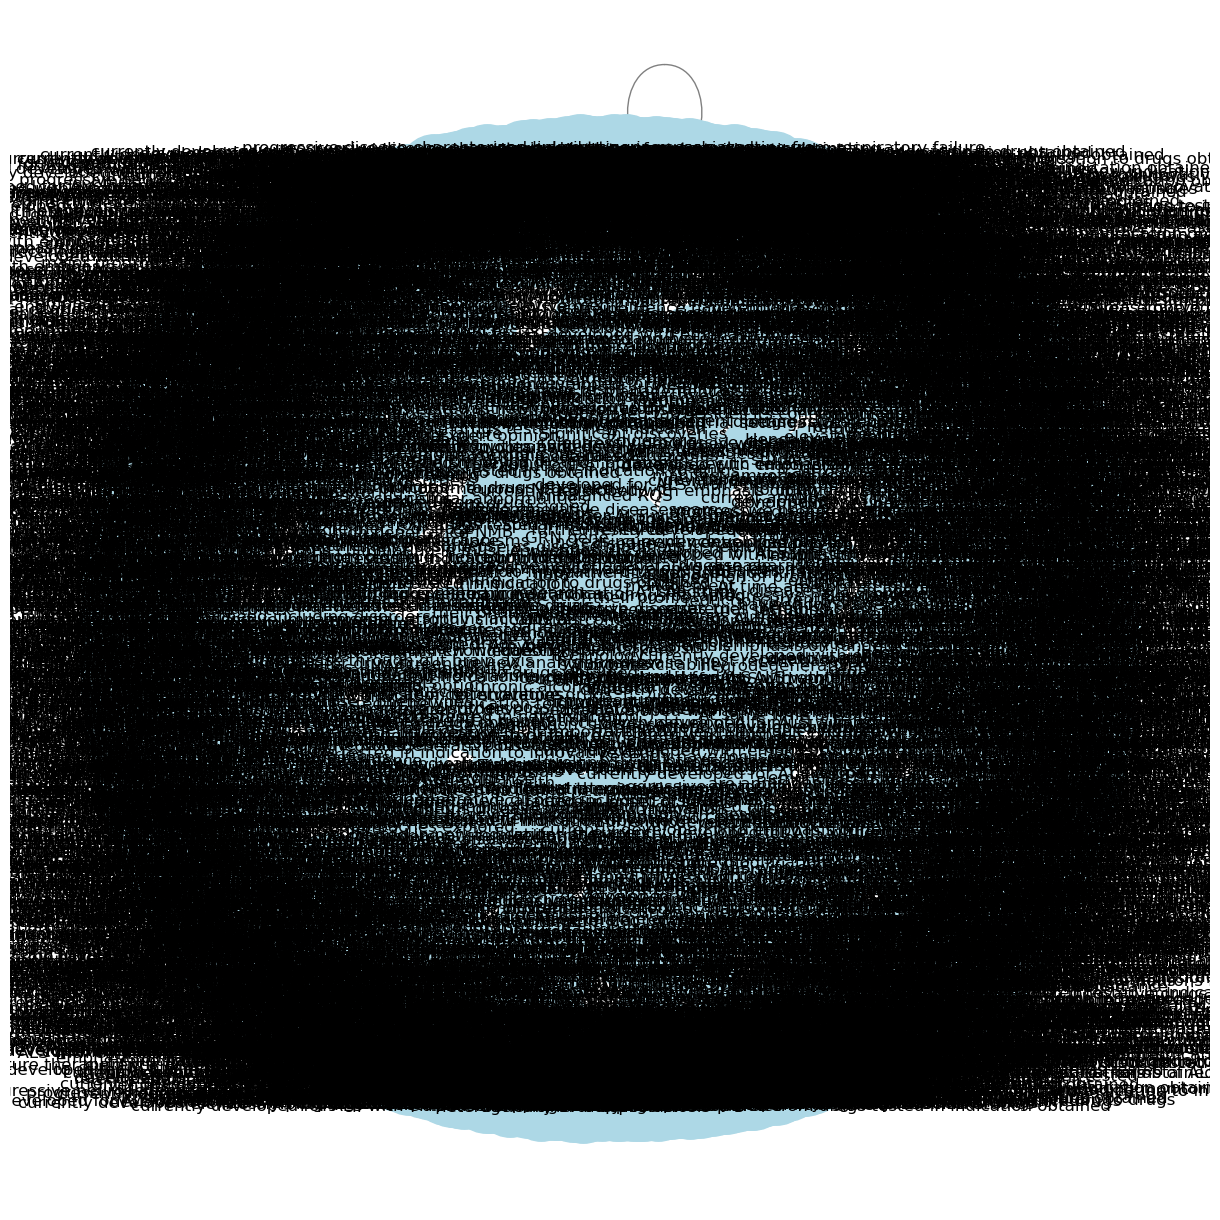

In [34]:
import networkx as nx
import matplotlib.pyplot as plt

# Creating a graph from the extracted relations
G = nx.Graph()

for index, row in df.iterrows():
    for relation in row['ExtractedRelations']:
        G.add_edge(relation['subject'], relation['object'], label=relation['relation'])

# plot the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2500, edge_color='gray')
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'label'))
plt.show()

## For one pmid

In [38]:
!pip install networkx matplotlib pyvis

In [79]:
print(df)

                                                Title      PMID  \
0                      Amyotrophic lateral sclerosis.  36116464   
1   Biomarkers inNeurodegenerativeDiseases: Proteo...  36012563   
2   Antisense Oligonucleotides for the Study andTr...  35653060   
3   iPSC-baseddiseasemodeling and drug discovery i...  35120619   
4   Supporting communication for patients withneur...  26409694   
5   StudyingALS: Current Approaches, Effect on Pot...  32383122   
6   Molecular mechanisms of cell death in neurolog...  34099897   
7                             Therapeutic news inALS.  33781562   
8   Rehabilitation in amyotrophic lateral sclerosi...  24510737   
9   Induced Pluripotent Stem Cell (iPSC)-BasedNeur...  32344649   
10  Amyotrophic lateral sclerosis: aneurodegenerat...  36543887   
11  Epigenetic Regulation inNeurodegenerativeDisea...  29885742   
12  Tauroursodeoxycholic acid: a potential therape...  35659112   
13  Care management in amyotrophic lateral sclerosis.  2846102

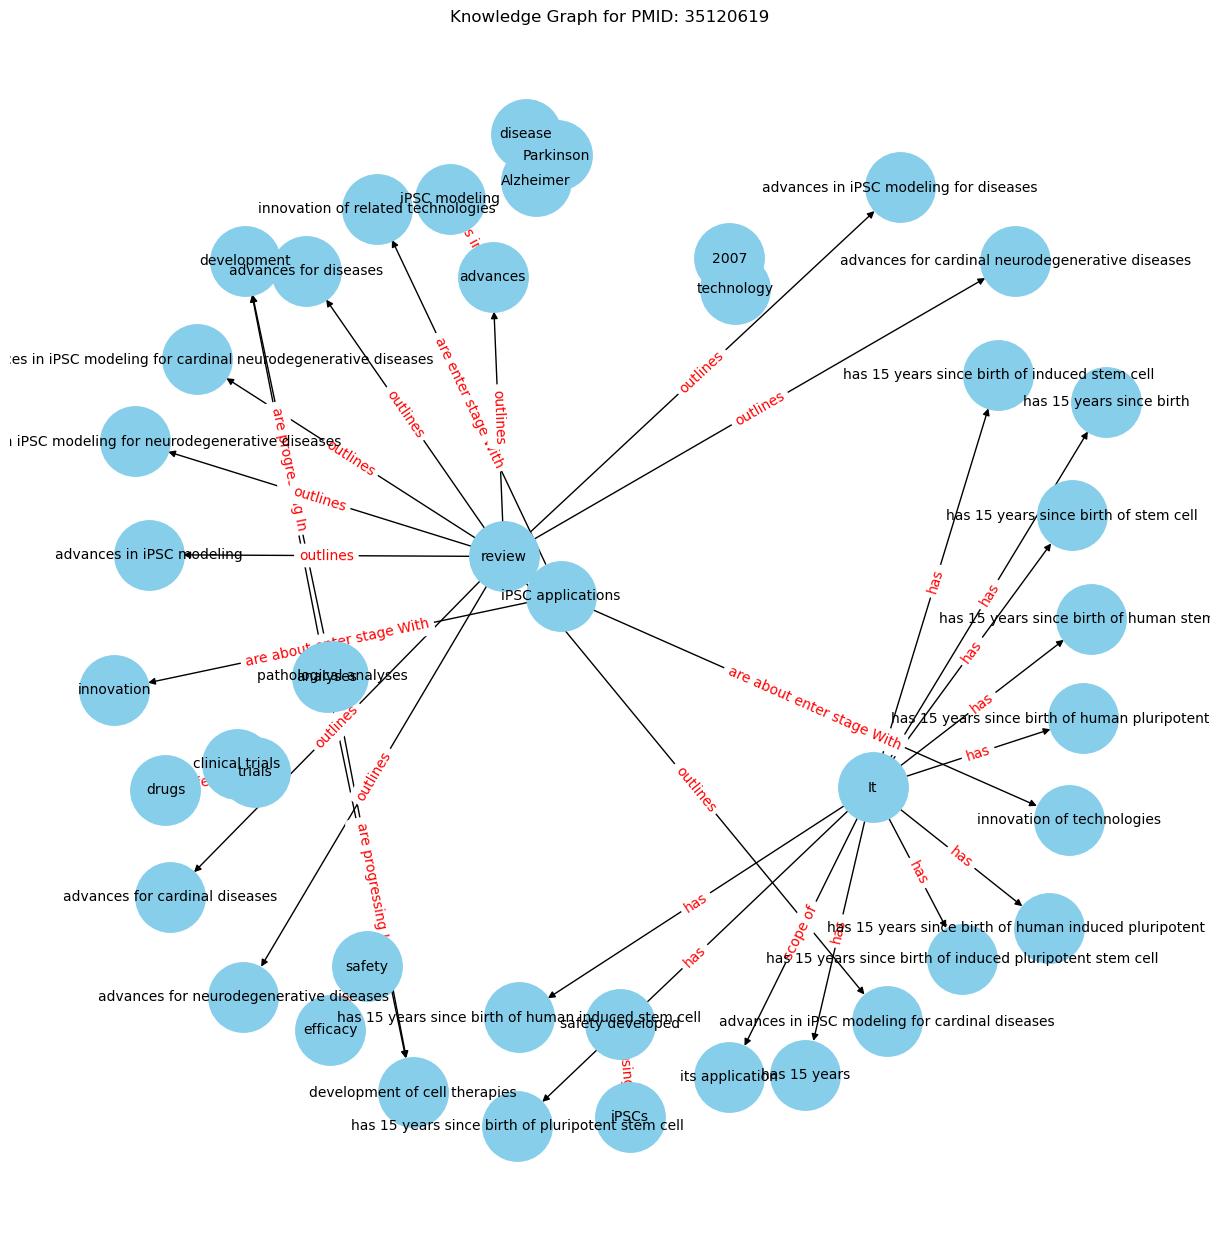

In [86]:
import networkx as nx
import matplotlib.pyplot as plt

# Function to build and show a knowledge graph for a single PMID
def visualize_knowledge_graph_for_pmid(df, pmid):
    pmid_data = df[df['PMID'] == pmid]
    
    if pmid_data.empty:
        print(f"No data found for PMID {pmid}")
        return

    relations = pmid_data.iloc[0]['ExtractedRelations']
    
    # Creating a directed graph
    G = nx.DiGraph()

    # Adding edges to the graph based on the relations
    for relation in relations:
        G.add_edge(relation['subject'], relation['object'], label=relation['relation'])

    # show the graph
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G)  
    nx.draw(G, pos, with_labels=True, node_size=2500, node_color='skyblue', edge_color='k', linewidths=1, font_size=10)
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    plt.title(f"Knowledge Graph for PMID: {pmid}")
    plt.show()

visualize_knowledge_graph_for_pmid(df, '35120619')